# Sequence Classification with linax

This notebook demonstrates how to train LinOSS[2] on the [MNIST SEQUENCE](https://edwin-de-jong.github.io/blog/mnist-sequence-data/) dataset using [`JAX`](https://github.com/google/jax), [`Equinox`](https://github.com/patrick-kidger/equinox) and **[`Linax`](https://github.com/tk-rusch/linoss)**.

### About Linax

**Linax** is a library for state-space sequence modeling built on JAX and Equinox. It provides:

- **Modern SSM architectures**: LRU, LinOSS and other state-of-the-art models
- **JAX-native**: JIT compilation and automatic differentiation
- **Clean API**: Built on Equinox for a PyTorch-like feel.

### About LinOSS

LinOSS (Linear Oscillatory State-Space) is a state-space sequence model based on forced harmonic oscillators, modeled after a system of independent, forced linear second-order ODEs.

### About the Dataset

In this example, we use the **MNIST Sequence dataset**, where handwritten digits are represented as sequences of pen strokes. Each timestep contains **4 features**:

- **dx, dy**: Pen movement offsets (relative displacement from previous position)
- **eos** (end-of-stroke): Binary flag indicating when the pen lifts off (value = 1)
- **eod** (end-of-digit): Binary flag indicating the end of the digit sequence (value = 1)

This encoding captures the **temporal dynamics** of how each digit was drawn, treating handwriting as a sequential process rather than a static image.

## Imports

We use:
- **Linax** - Our SSM library providing the core building blocks
- **JAX/Equinox** - Foundation libraries for the model definition and training loop
- **PyTorch** - For efficient data loading via DataLoader (converted to NumPy for JAX)
- **Optax** - For optimization
- **jaxtyping** - For type annotations with array shapes


In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import optax
import torch
from datasets import MNISTSeq
from jaxtyping import Array, Float, Int, PRNGKeyArray, PyTree
from tqdm import tqdm

from linax.encoder import LinearEncoderConfig
from linax.heads.classification import ClassificationHeadConfig
from linax.models.linoss import LinOSSConfig
from linax.models.ssm import SSM

## Hyperparameters

We define our training configuration. These values have been chosen for effective training:

- **Batch Size**: 32 samples per batch (good balance between speed and stability)
- **Learning Rate**: $3 \times 10^{-4}$
- **Steps**: 7500 training steps (approximately 5 epochs)
- **Print Every**: for evaluating every $1500$ steps (approximately every epoch)
- **Num Blocks**: 10 LinOSS blocks for the model architecture

In [ ]:
# Training configuration
# With these parameters the training time is around 17 minutes.
BATCH_SIZE = 32  # Number of samples per batch
LEARNING_RATE = 3e-4  # AdamW learning rate
STEPS = 7500  # Total training steps.
PRINT_EVERY = 1500  # Evaluation frequency.
SEED = 5678  # Random seed for reproducibility
NUM_BLOCKS = 10  # Number of LinOSS blocks

# random keys take care of randomness in JAX
key = jax.random.PRNGKey(SEED)

## Data Loading 📊

We load the **MNIST Sequence dataset** where handwritten digits are represented as sequences of pen strokes.

### Dataset Details:
- **Sequences**: Each sample is 128 timesteps long
- **Features**: 4 features per timestep
  - `dx, dy`: Pen movement offsets (relative displacement)
  - `eos`: End-of-stroke marker (pen lift)
  - `eod`: End-of-digit marker (sequence end)
- **Labels**: Digit class (0-9)

### Preprocessing:
The `MNISTSeq` dataset automatically:
1. Downloads the data from the official source
2. Pads/truncates sequences to fixed length (128)
3. Returns PyTorch tensors (which we convert to NumPy for JAX)

In [ ]:
# Load MNIST Sequence dataset
train_dataset = MNISTSeq(root="../../data_dir", train=True, download=True)

test_dataset = MNISTSeq(root="../../data_dir", train=False, download=True)

# Create DataLoaders for efficient batching
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Inspecting the Data 🔍

Let's verify our data shapes and examine a sample batch to ensure everything is loaded correctly.

**Expected shapes:**
- `x`: `(batch_size, 128, 4)` - sequences of pen strokes with 4 features per timestep
- `y`: `(batch_size,)` - class labels (digits 0-9)

In [4]:
# Get a sample batch to verify shapes
dummy_x, dummy_y = next(iter(trainloader))
dummy_x = dummy_x.numpy()
dummy_y = dummy_y.numpy()
print(f"Input shape: {dummy_x.shape}")  # (batch_size, 128, 4)
print(f"Label shape: {dummy_y.shape}")  # (batch_size,)
print(f"Sample labels: {dummy_y}")  # Example digit labels

Input shape: (32, 128, 4)
Label shape: (32,)
Sample labels: [7 2 2 4 2 9 7 1 6 3 2 2 9 1 3 4 7 3 1 0 2 1 3 2 7 1 0 7 1 4 0 2]


### Visualizing MNIST Sequences

Let's visualize some samples from the training set to see what our model will be learning from. Each visualization shows how the pen strokes form the digit:

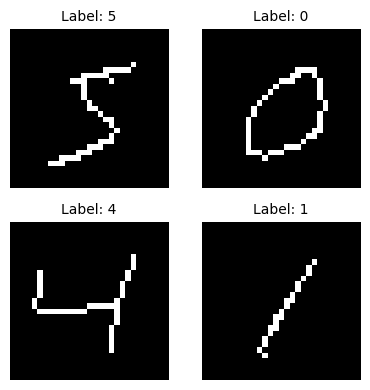

In [5]:
train_dataset.plot_samples(num_samples=4, figsize=(4, 4))

## Model Architecture

We'll build a LinOSS model using Linax's configuration system. The model consists of three main components:

1. **Encoder**: Transforms input sequences (4 features) to a higher-dimensional space (64 features)
2. **SSM Blocks**: Stacked LinOSS blocks that process the sequences using oscillatory dynamics
3. **Classification Head**: Maps the final representation to class probabilities (10 digits)

### Configuration Parameters:

- `num_blocks`: Number of stacked LinOSS layers (configurable via `NUM_BLOCKS`)
- `encoder_config`: Defines the input projection (4 → 64 dimensions)
- `head_config`: Defines the output layer (64 → 10 classes)

In [6]:
linoss_cfg = LinOSSConfig(
    num_blocks=NUM_BLOCKS,
    encoder_config=LinearEncoderConfig(in_features=4, out_features=64),
    head_config=ClassificationHeadConfig(out_features=10),
)

Next, we build the model from the config

In [7]:
key, subkey = jax.random.split(key, 2)

model = linoss_cfg.build(key=subkey)

state = eqx.nn.State(model=model)

### Model Summary

Let's inspect the model to see its architecture and parameter count. 

**What to look for:**
- Total parameters (scales with `NUM_BLOCKS` - lightweight for sequence modeling!)
- Each block has ~25K parameters
- IMEX discretization scheme for numerical stability
- Dropout rate of 0.1 for regularization
- With `NUM_BLOCKS=10`, total is ~250K parameters

In [8]:
print(model)

╔════════════════════════════════════════════════════════════════════════╗
║                           SSM Model Summary                            ║
╠════════════════════════════════════════════════════════════════════════╣
║ Components:                                                            ║
║   Encoder:  LinearEncoder (256 params)                                 ║
║   Blocks:   10× LinOSSBlock (total 250,880 params)                     ║
║     [0] 25,088 params | IMEX | damp:✓ | GLU(64→64) | drop:0.10         ║
║     [1] 25,088 params | IMEX | damp:✓ | GLU(64→64) | drop:0.10         ║
║     [2] 25,088 params | IMEX | damp:✓ | GLU(64→64) | drop:0.10         ║
║     [3] 25,088 params | IMEX | damp:✓ | GLU(64→64) | drop:0.10         ║
║     [4] 25,088 params | IMEX | damp:✓ | GLU(64→64) | drop:0.10         ║
║     [5] 25,088 params | IMEX | damp:✓ | GLU(64→64) | drop:0.10         ║
║     [6] 25,088 params | IMEX | damp:✓ | GLU(64→64) | drop:0.10         ║
║     [7] 25,088 params |

## Loss Function

We train our model using the **cross-entropy loss** for multi-class classification.

### Implementation Details:

- **Batched computation**: `jax.vmap` processes all samples in parallel for efficiency
- **Stateful forward pass**: Model state (e.g., batch norm statistics) is threaded through computation
- **Axis naming**: `axis_name="batch"` enables collective operations across the batch dimension

**Expected initial loss:** ~2.3 = log(10), which corresponds to random guessing among 10 classes.


In [9]:
def loss(
    model: SSM,
    x: Float[Array, "batch 128 4"],
    y: Int[Array, " batch"],
    state: eqx.nn.State,
    key: PRNGKeyArray,
) -> Float[Array, ""]:
    """Apply loss function to the model.

    Returns the cross entropy loss given x and y as well as the updated model state.
    """
    batch_keys = jax.random.split(key, x.shape[0])

    # this vmap parallelizes the model over the batch dimension (which is the first dimension).
    pred_y, model_state = jax.vmap(
        model,
        axis_name="batch",
        in_axes=(0, None, 0),
        out_axes=(0, None),
    )(x, state, batch_keys)
    return cross_entropy(y, pred_y), model_state


def cross_entropy(y: Int[Array, " batch"], pred_y: Float[Array, "batch 10"]) -> Float[Array, ""]:
    """Cross entropy loss function."""
    pred_y = jnp.take_along_axis(pred_y, jnp.expand_dims(y, 1), axis=1)
    return -jnp.mean(pred_y)


# Test the loss function on our sample batch
loss_value, _ = loss(model, dummy_x, dummy_y, state, key)
print(f"Loss shape: {loss_value.shape}")  # Should be scalar ()
print(f"Initial loss value: {loss_value:.4f}")
# Should be around log(10) ≈ 2.3 for random predictions

Loss shape: ()
Initial loss value: 2.3367


### Testing Gradient Computation

Before training, let's verify that gradients flow correctly through the model. We use `eqx.filter_value_and_grad` with `has_aux=True` to compute gradients while also getting the updated model state.

**Note:** You may see a `ComplexWarning` - this is expected! LinOSS uses complex-valued internal representations that are converted to real values for reading out the hidden states.

In [10]:
(loss_value, new_state), grads = eqx.filter_value_and_grad(loss, has_aux=True)(
    model, dummy_x, dummy_y, state, key
)

/Users/shox/dev/phd/ssm_dir/linax/.venv/lib/python3.12/site-packages/jax/_src/lax/lax.py:5473: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


In [11]:
print(f"Loss after gradient computation: {loss_value:.4f}")

Loss after gradient computation: 2.3367


## Evaluation Metrics

In addition to loss, we track **classification accuracy** to better understand model performance.


In [12]:
loss = eqx.filter_jit(loss)  # JIT our loss function from earlier!


@eqx.filter_jit
def compute_accuracy(
    model: SSM,
    x: Float[Array, "batch 128 4"],
    y: Int[Array, " batch"],
    state: eqx.nn.State,
    key: PRNGKeyArray,
) -> Float[Array, ""]:
    """Computes the average accuracy on a batch."""
    batch_keys = jax.random.split(key, x.shape[0])

    pred_y, _ = jax.vmap(
        model,
        axis_name="batch",
        in_axes=(0, None, 0),
        out_axes=(0, None),
    )(x, state, batch_keys)
    pred_y = jnp.argmax(pred_y, axis=1)
    return jnp.mean(y == pred_y)

### Test Set Evaluation

This function evaluates the model on the entire test set by iterating through all test batches.

**Inference Mode**: We use `eqx.tree_inference(model, value=True)` to switch to inference mode.

In [13]:
def evaluate(
    model: SSM,
    testloader: torch.utils.data.DataLoader,
    state: eqx.nn.State,
    key: PRNGKeyArray,
):
    """Evaluates the model on the test dataset."""
    inference_model = eqx.tree_inference(model, value=True)
    avg_loss = 0
    avg_acc = 0
    for x, y in tqdm(testloader, desc="Evaluating"):
        x = x.numpy()
        y = y.numpy()
        # Note that all the JAX operations happen inside `loss` and `compute_accuracy`,
        # and both have JIT wrappers, so this is fast.
        avg_loss += loss(inference_model, x, y, state, key)[0]
        avg_acc += compute_accuracy(inference_model, x, y, state, key)
    return avg_loss / len(testloader), avg_acc / len(testloader)

## Optimizer Setup

We use the **AdamW** optimizer from Optax, which is Adam with decoupled weight decay regularization.

In [14]:
optim = optax.adamw(LEARNING_RATE)

## Training Loop

Now let's train the model!

### Expected Results:

With the default configuration (`BATCH_SIZE=32`, `NUM_BLOCKS=10`, `STEPS=7500`):

- **Initial accuracy**: ~10-12% (random guessing among 10 classes)
- **After 1500 steps** (~1 epoch): ~91% accuracy
- **After 3000 steps** (~2 epochs): ~94% accuracy
- **After 7500 steps** (~5 epochs): **~96% accuracy**

Training takes approximately **17 minutes** with these settings.

Time to train!


In [15]:
def train(
    model: SSM,
    trainloader: torch.utils.data.DataLoader,
    testloader: torch.utils.data.DataLoader,
    optim: optax.GradientTransformation,
    steps: int,
    print_every: int,
    state: eqx.nn.State,
    key: PRNGKeyArray,
) -> SSM:
    """Trains the model on the training dataset."""
    # Just like earlier: It only makes sense to train the arrays in our model,
    # so filter out everything else.
    opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

    # Always wrap everything -- computing gradients, running the optimizer, updating
    # the model -- into a single JIT region. This ensures things run as fast as
    # possible.
    @eqx.filter_jit
    def make_step(
        model: SSM,
        opt_state: PyTree,
        x: Float[Array, "batch 128 4"],
        y: Int[Array, " batch"],
        state: eqx.nn.State,
        key: PRNGKeyArray,
    ):
        (loss_value, new_state), grads = eqx.filter_value_and_grad(loss, has_aux=True)(
            model, x, y, state, key
        )
        updates, opt_state = optim.update(
            grads, opt_state, eqx.filter(model, eqx.is_inexact_array)
        )
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value, new_state

    # Loop over our training dataset as many times as we need.
    def infinite_trainloader():
        while True:
            yield from trainloader

    key, train_key = jax.random.split(key, 2)

    for step, (x, y) in zip(tqdm(range(steps)), infinite_trainloader()):
        # PyTorch dataloaders give PyTorch tensors by default,
        # so convert them to NumPy arrays.
        x = x.numpy()
        y = y.numpy()
        model, opt_state, train_loss, new_state = make_step(
            model, opt_state, x, y, state, train_key
        )

        if (step % print_every) == 0 or (step == steps - 1):
            test_loss, test_accuracy = evaluate(model, testloader, new_state, key)
            print(
                f"{step=}, train_loss={train_loss.item()}, "
                f"test_loss={test_loss.item()}, test_accuracy={test_accuracy.item()}"
            )
    return model

In [16]:
model = train(model, trainloader, testloader, optim, STEPS, PRINT_EVERY, state, key)

  0%|          | 2/7500 [00:33<28:29:19, 13.68s/it]

step=0, train_loss=2.368354082107544, test_loss=2.3261163234710693, test_accuracy=0.1006389781832695


 20%|██        | 1502/7500 [04:00<5:22:17,  3.22s/it]

step=1500, train_loss=0.6817602515220642, test_loss=0.3043871223926544, test_accuracy=0.9091453552246094


 40%|████      | 3002/7500 [07:31<4:24:02,  3.52s/it]

step=3000, train_loss=0.12930883467197418, test_loss=0.1924053579568863, test_accuracy=0.9401956796646118


 60%|██████    | 4502/7500 [10:57<2:38:41,  3.18s/it]

step=4500, train_loss=0.5353334546089172, test_loss=0.17053061723709106, test_accuracy=0.9477835297584534


 80%|████████  | 6002/7500 [14:25<1:19:45,  3.19s/it]

step=6000, train_loss=0.2455877959728241, test_loss=0.13679201900959015, test_accuracy=0.9574680328369141


100%|██████████| 7500/7500 [17:52<00:00,  6.99it/s]

step=7499, train_loss=0.2593978941440582, test_loss=0.15777377784252167, test_accuracy=0.9515774846076965


In this notebook, you learned how to:
- ✅ Load and visualize sequential data (MNIST Sequence dataset)
- ✅ Configure and build a LinOSS model using Linax
- ✅ Set up training with JAX, Equinox, and Optax
- ✅ Train a state space model and monitor its performance

**What's Next?** 🚀

Continue by exploring the next notebooks, where you'll dive deeper into:
- SSM for regression problems
- Advanced SSM architectures (LRU, S4, S5)
- Configurable SSM architectures

## References

1. **Linax GitHub Repository**: https://github.com/camail-official/linax (⭐ Star the repo!)
2. **LinOSS Paper**: Rusch, T. K., & Rus, D. (2024). "Oscillatory State-Space Models". https://openreview.net/forum?id=GRMfXcAAFh
3. **Equinox Documentation**: https://docs.kidger.site/equinox/
4. **JAX Documentation**: https://jax.readthedocs.io/
5. **MNIST SEQUENCE Dataset**: https://edwin-de-jong.github.io/blog/mnist-sequence-data/